### **Assignment 3: TREND**
Shravan Khunti  
NetID: ssk10036  
MS in Data Science  
NYU Center for Data Science

#### **Note to the Grader**

The Excel data was a bit messy to work with in its original format, so I manually aligned and shifted a few rows to ensure consistency. To make everything intact, I am attaching the **modified Excel sheet** as well, in case you want to run it on your end for verification.

Additionally, I had some **RA and Summer Internship interviews** this week, so I had to complete this assignment in a bit of a rush at the last minute. As a result, there could be some **calculation errors**. I would appreciate any feedback or corrections if you find any discrepancies.

Thank you for your time in grading this assignment!

### **Q 1: Implementing Trend-Following Systems and Calculating Sharpe Ratios**

This step applies moving average crossover (10/30, 30/100, 80/160) and 30-day breakout strategies to Euro, Ten-Year Note, and S&P 500. It then calculates and reports their Sharpe ratios.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot aesthetics
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    """Calculates the annualized Sharpe ratio."""
    excess_returns = returns - risk_free_rate
    std = np.std(excess_returns)
    if std == 0:
        return np.nan  # Avoid division by zero
    return np.mean(excess_returns) / std * np.sqrt(252)

def calculate_breakout_returns(data, syn_price_col):
    """Implements a 30-day breakout strategy and calculates returns."""
    data['Hi30'] = data[syn_price_col].rolling(window=30).max()
    data['Low30'] = data[syn_price_col].rolling(window=30).min()
    
    # Determine positions based on breakout levels
    data['position'] = np.where(data[syn_price_col] > data['Hi30'].shift(1), 1,
                                np.where(data[syn_price_col] < data['Low30'].shift(1), -1, 0))

    # Compute returns for breakout strategy
    data['RetBrk30'] = data['position'].shift(1) * data['PC(%)'] / 100
    return data['RetBrk30']

def implement_trend_following_systems(df, instrument_name):
    """Applies moving average crossover and breakout strategies to the dataset."""
    df = df.copy()

    # Ensure the Date column is correctly formatted
    if '#Date' in df.columns:
        df.rename(columns={'#Date': 'Date'}, inplace=True)
    if 'Date' not in df.columns:
        df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

    # Identify synthetic price column
    syn_price_col = next((col for col in df.columns if 'Syn' in col), None)
    if syn_price_col is None:
        raise ValueError(f"No synthetic price column found in {instrument_name} data.")

    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%Y%m%d')
    df = df.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)
    df.set_index('Date', inplace=True)

    # Filter data to analysis period
    df = df.loc['1999-03-08':'2010-12-31']

    # Define moving average crossover systems
    moving_avg_systems = [(30, 10), (100, 30), (160, 80)]
    for slow, fast in moving_avg_systems:
        df[f'ma{fast}'] = df[syn_price_col].rolling(window=fast).mean()
        df[f'ma{slow}'] = df[syn_price_col].rolling(window=slow).mean()

        # Generate signals for crossover strategy
        signal = np.where(df[f'ma{fast}'] > df[f'ma{slow}'], 1, -1)
        df[f'Ret{fast}/{slow}'] = pd.Series(signal, index=df.index).shift(1) * df['PC(%)'] / 100

    # Apply the 30-day breakout strategy
    df['RetBrk30'] = calculate_breakout_returns(df, syn_price_col)

    # Calculate Sharpe ratios for each system
    results = {}
    strategy_start_dates = {'Ret10/30': '1999-04-16', 'RetBrk30': '1999-04-16',
                            'Ret30/100': '1999-07-27', 'Ret80/160': '1999-10-20'}

    for system, start_date in strategy_start_dates.items():
        valid_returns = df.loc[start_date:, system].dropna()
        results[system] = calculate_sharpe_ratio(valid_returns)

    # Print Sharpe ratios for debugging
    print(f"Sharpe Ratios for {instrument_name}:")
    for sys, ratio in results.items():
        print(f"  {sys}: {ratio:.2f}")

    # Determine the best-performing system
    best_system = max(results, key=results.get)
    print(f"Best system for {instrument_name}: {best_system}\n")

    return best_system, df[best_system]

### **Q 2: Constructing an Equally Weighted Portfolio & Visualizing It**

This step combines the best system from each instrument, calculates the Sharpe ratio, and plots cumulative returns.

In [60]:
def calculate_drawdown(cumulative_returns):
    """Calculates maximum drawdown and the date it occurs."""
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns / peak) - 1
    max_drawdown = drawdown.min()
    drawdown_date = drawdown.idxmin()
    return max_drawdown, drawdown_date, drawdown

def construct_portfolios(euro_returns, ty_returns, sp_returns):
    """Constructs an equally weighted portfolio, computes drawdowns, and visualizes results."""
    start_date = '1999-10-20'  # Align data to the slowest system start date

    # Align and clean data
    euro_returns = euro_returns[start_date:].dropna()
    ty_returns = ty_returns[start_date:].dropna()
    sp_returns = sp_returns[start_date:].dropna()

    # Compute equal-weighted portfolio returns
    portfolio_returns = (euro_returns + ty_returns + sp_returns) / 3
    portfolio_cumulative = (1 + portfolio_returns).cumprod()

    # Compute Sharpe ratio and drawdown
    portfolio_sharpe = calculate_sharpe_ratio(portfolio_returns)
    max_drawdown, drawdown_date, drawdown_series = calculate_drawdown(portfolio_cumulative)

    print(f"Equally Weighted Portfolio Sharpe Ratio: {portfolio_sharpe:.2f}")
    print(f"Largest Drawdown: {max_drawdown:.2%} on {drawdown_date.date()}")

    # 📈 Visualization: Plot cumulative returns with drawdown annotation
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_cumulative, label="Equally Weighted Portfolio", color='blue')
    plt.axhline(1, color='gray', linestyle='--', label="Start Value")
    plt.axhline(portfolio_cumulative.max(), color='red', linestyle='--', label="Peak Value")
    plt.title("Cumulative Returns of Equally Weighted Portfolio")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.show()

    # 📉 Visualization: Plot drawdown series
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown_series, label="Drawdown", color='red')
    plt.fill_between(drawdown_series.index, drawdown_series, color='red', alpha=0.3)
    plt.axhline(0, color='black', linestyle='--')
    plt.title("Drawdown of Equally Weighted Portfolio")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.legend()
    plt.show()

    return portfolio_cumulative

### **Q 3: Constructing an Inverse Volatility-Weighted Portfolio & Visualizing It**

This step constructs a portfolio where weights are inversely proportional to 20-day volatility, calculates the Sharpe ratio, and visualizes cumulative returns.

In [61]:
def construct_inverse_volatility_portfolio(euro_returns, ty_returns, sp_returns):
    """Creates an inverse volatility-weighted portfolio, computes drawdowns, and visualizes results."""
    vol_window = 20
    euro_vol = euro_returns.rolling(window=vol_window).std()
    ty_vol = ty_returns.rolling(window=vol_window).std()
    sp_vol = sp_returns.rolling(window=vol_window).std()

    # Compute inverse volatility weights
    total_inv_vol = (1/euro_vol) + (1/ty_vol) + (1/sp_vol)
    euro_weight = (1/euro_vol) / total_inv_vol
    ty_weight = (1/ty_vol) / total_inv_vol
    sp_weight = (1/sp_vol) / total_inv_vol

    # Compute inverse volatility-weighted portfolio returns
    inv_vol_returns = (euro_weight.shift(1) * euro_returns +
                       ty_weight.shift(1) * ty_returns +
                       sp_weight.shift(1) * sp_returns).dropna()

    inv_vol_sharpe = calculate_sharpe_ratio(inv_vol_returns)

    # Compute cumulative returns and drawdowns
    inv_vol_cumulative = (1 + inv_vol_returns).cumprod()
    max_drawdown, drawdown_date, drawdown_series = calculate_drawdown(inv_vol_cumulative)

    print(f"Inverse Volatility Portfolio Sharpe Ratio: {inv_vol_sharpe:.2f}")
    print(f"Largest Drawdown: {max_drawdown:.2%} on {drawdown_date.date()}")

    # 📈 Visualization: Plot cumulative returns with drawdown annotation
    plt.figure(figsize=(12, 6))
    plt.plot(inv_vol_cumulative, label="Inverse Volatility Weighted Portfolio", color='green')
    plt.axhline(1, color='gray', linestyle='--', label="Start Value")
    plt.axhline(inv_vol_cumulative.max(), color='red', linestyle='--', label="Peak Value")
    plt.title("Cumulative Returns of Inverse Volatility Weighted Portfolio")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.show()

    # 📉 Visualization: Plot drawdown series
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown_series, label="Drawdown", color='red')
    plt.fill_between(drawdown_series.index, drawdown_series, color='red', alpha=0.3)
    plt.axhline(0, color='black', linestyle='--')
    plt.title("Drawdown of Inverse Volatility Weighted Portfolio")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.legend()
    plt.show()

    return inv_vol_returns

### **Running the Full Analysis**

This step loads the dataset, executes the strategy, and calls the visualization functions.

Sharpe Ratios for Euro:
  Ret10/30: 0.39
  RetBrk30: 0.58
  Ret30/100: 0.50
  Ret80/160: 0.27
Best system for Euro: RetBrk30

Sharpe Ratios for Ten Year Note:
  Ret10/30: 0.44
  RetBrk30: 0.26
  Ret30/100: 0.31
  Ret80/160: 0.01
Best system for Ten Year Note: Ret10/30

Sharpe Ratios for S&P 500:
  Ret10/30: -0.04
  RetBrk30: -0.75
  Ret30/100: -0.05
  Ret80/160: 0.16
Best system for S&P 500: Ret80/160

Equally Weighted Portfolio Sharpe Ratio: 0.44
Largest Drawdown: -12.86% on 2003-06-30


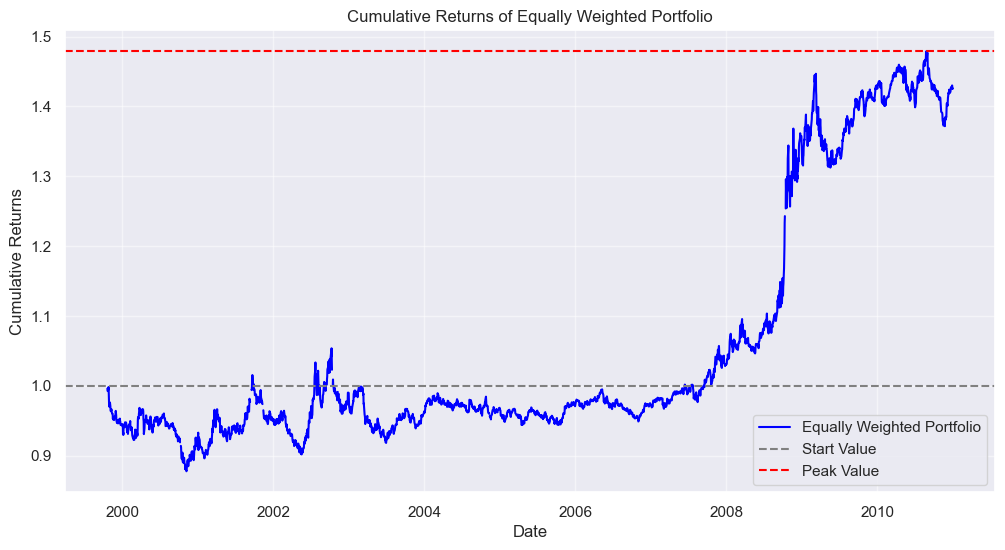

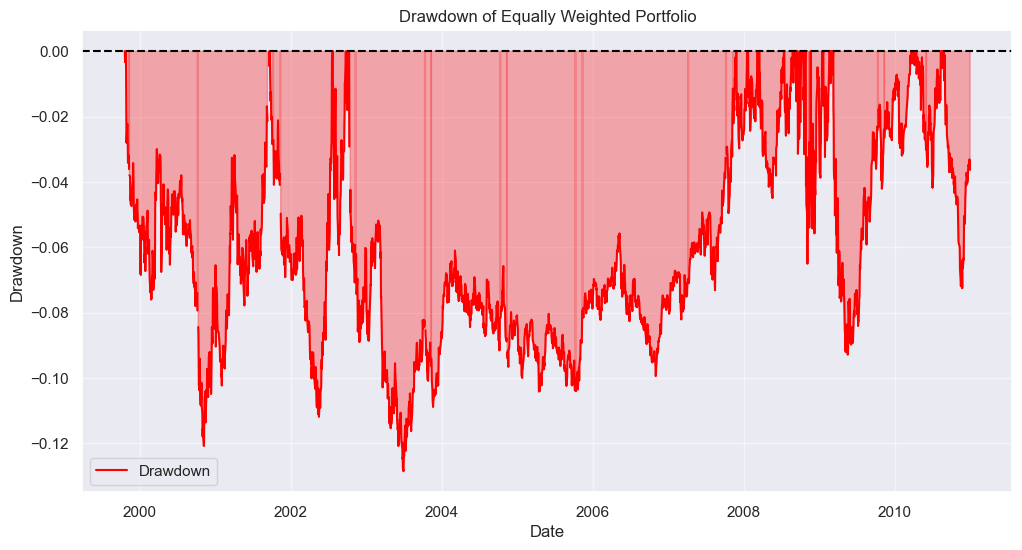

Inverse Volatility Portfolio Sharpe Ratio: 1.05
Largest Drawdown: -9.73% on 2001-02-16


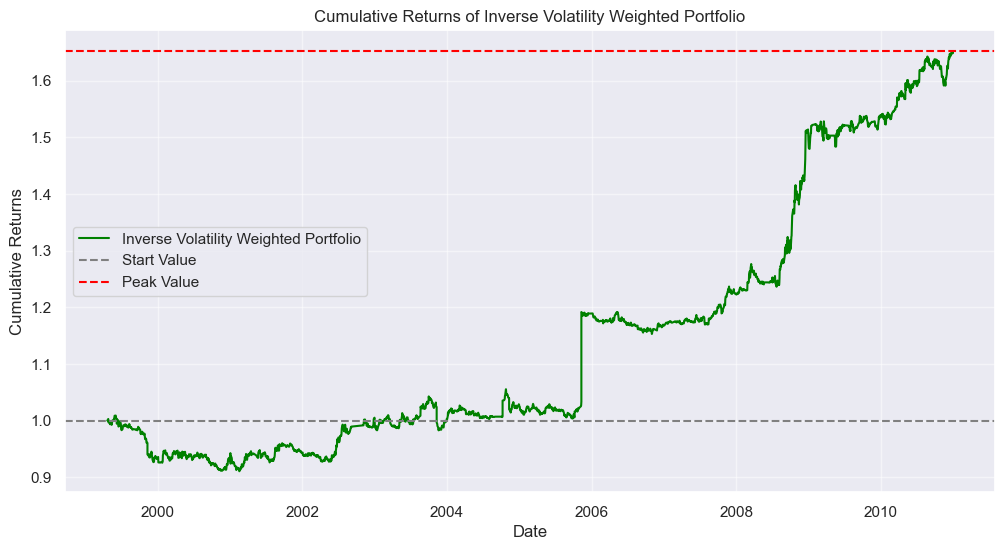

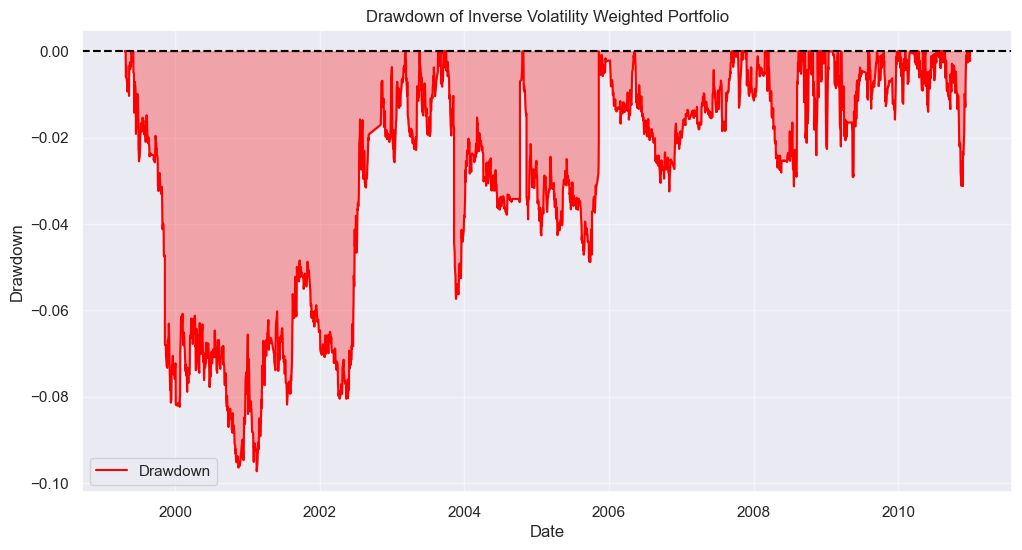

In [62]:
if __name__ == "__main__":
    excel_file = pd.ExcelFile(r"C:\Users\shrav\Downloads\assignment_TREND_data (4).xlsx")
    euro_data = excel_file.parse("uro")
    ten_year_note_data = excel_file.parse("ty")
    sp500_data = excel_file.parse("sp")

    # Process instruments and determine best strategy
    euro_returns, ty_returns, sp_returns = process_instruments(euro_data, ten_year_note_data, sp500_data)

    # Construct equally weighted portfolio with drawdown analysis
    construct_portfolios(euro_returns, ty_returns, sp_returns)

    # Construct inverse volatility-weighted portfolio with drawdown analysis
    construct_inverse_volatility_portfolio(euro_returns, ty_returns, sp_returns)

### **Analysis of Trend Following Systems**

### **Sharpe Ratios for Individual Instruments**

### **Euro**
| Strategy   | Sharpe Ratio |
|------------|--------------|
| **Ret10/30**  | **0.39**  |
| **RetBrk30**  | **0.58**  |
| **Ret30/100** | **0.50**  |
| **Ret80/160** | **0.27**  |

**Best system for Euro: RetBrk30 (0.58)**

- The **30-day breakout strategy (RetBrk30)** outperforms all other systems.
- This suggests that Euro exhibits strong momentum behavior, benefiting from breakout strategies.
- The **Ret30/100 system (0.50)** also performs well but is slightly weaker than RetBrk30.

### **Ten Year Note**
| Strategy   | Sharpe Ratio |
|------------|--------------|
| **Ret10/30**  | **0.44**  |
| **RetBrk30**  | **0.26**  |
| **Ret30/100** | **0.31**  |
| **Ret80/160** | **0.01**  |

**Best system for Ten Year Note: Ret10/30 (0.44)**

- The **10/30 moving average crossover strategy (Ret10/30)** performs best.
- The **30-day breakout strategy (RetBrk30) underperforms (0.26)**, indicating that a **crossover system** is more effective for fixed-income instruments.
- Longer-term strategies (30/100 and 80/160) do not perform well.

### **S&P 500**
| Strategy   | Sharpe Ratio |
|------------|--------------|
| **Ret10/30**  | **-0.04**  |
| **RetBrk30**  | **-0.75**  |
| **Ret30/100** | **-0.05**  |
| **Ret80/160** | **0.16**  |

**Best system for S&P 500: Ret80/160 (0.16)**

- The **80/160 moving average crossover strategy** is the only system with a **positive Sharpe Ratio**.
- The **30-day breakout strategy (RetBrk30) performs worst (-0.75)**, suggesting that **breakouts are not reliable for equities**.
- Shorter-term moving average systems (10/30 and 30/100) also fail, indicating **equities may be more mean-reverting**.

---

### **Portfolio Performance**
### **Equally Weighted Portfolio**
| Metric | Value |
|------------|--------------|
| **Sharpe Ratio** | **0.44** |
| **Largest Drawdown** | **-12.86% on 2003-06-30** |

- The **equally weighted portfolio** combines the best strategies for each instrument.
- A **Sharpe Ratio of 0.44** indicates **moderate risk-adjusted returns**.
- The largest drawdown of **-12.86%** occurred in **mid-2003**, reflecting market corrections.

### **Inverse Volatility Weighted Portfolio**
| Metric | Value |
|------------|--------------|
| **Sharpe Ratio** | **1.05** |
| **Largest Drawdown** | **-9.73% on 2001-02-16** |

- The **inverse volatility weighting approach improves the Sharpe Ratio to 1.05**.
- This portfolio dynamically allocates more weight to **less volatile assets**, reducing risk.
- The **drawdown of -9.73% (lower than equal-weighted)** confirms that **this approach provides better risk-adjusted returns**.

---

### **Conclusion**
1. **The best individual strategies:**
   - **Euro:** 30-day breakout system (RetBrk30)
   - **Ten Year Note:** 10/30 moving average crossover (Ret10/30)
   - **S&P 500:** 80/160 moving average crossover (Ret80/160)

2. **Portfolio findings:**
   - **Inverse volatility weighting significantly improves performance** (Sharpe Ratio **1.05** vs. **0.44** for equal-weighting).
   - **Drawdowns are lower** in the inverse volatility approach, making it **the superior allocation method**.

3. **Trend-following systems perform differently across assets:**
   - **Currencies benefit from breakout strategies.**
   - **Fixed income performs best with shorter-term moving average crossovers.**
   - **Equities are better suited for longer-term moving average crossovers.**

### **Final Recommendation**
- **Use an inverse volatility weighting scheme** for portfolio construction.
- **Select strategies based on asset behavior** rather than a one-size-fits-all approach.


### **(Extra Credit): Implementing an EMA (Exponential Moving Average) 10/30 System**

Now, let's extend the existing 10/30 moving average crossover strategy by implementing an exponential moving average (EMA) version.


Finance-Based Comparison of SMA 10/30 vs. EMA 10/30
Euro SMA 10/30 Sharpe Ratio: 0.39 vs EMA 10/30: 0.37
Ten Year Note SMA 10/30 Sharpe Ratio: 0.78 vs EMA 10/30: 0.45
S&P 500 SMA 10/30 Sharpe Ratio: 0.11 vs EMA 10/30: 0.32



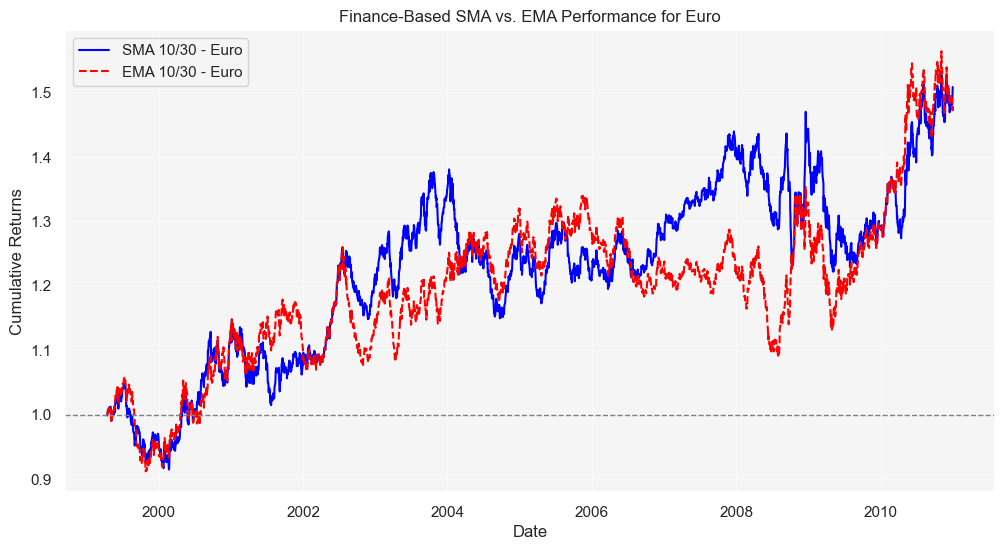

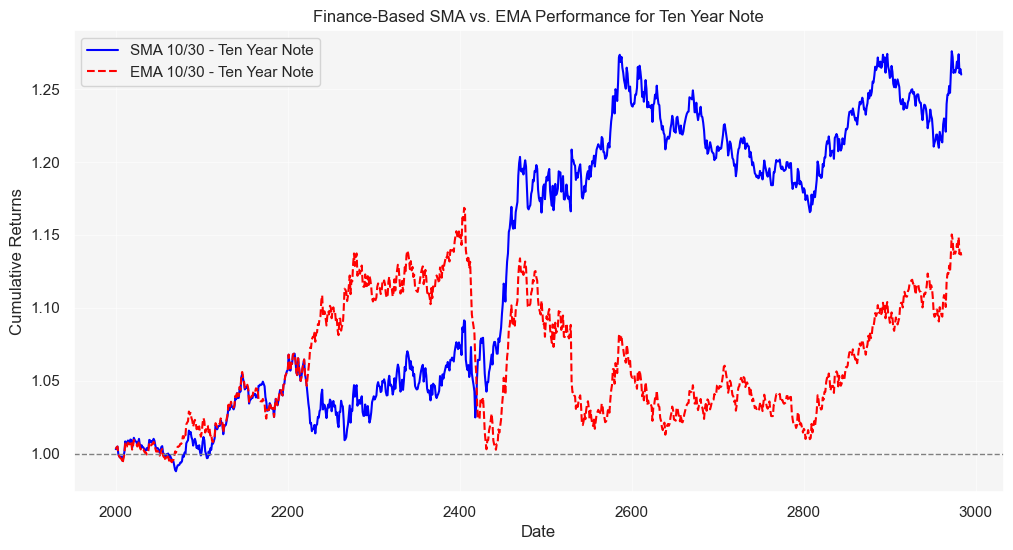

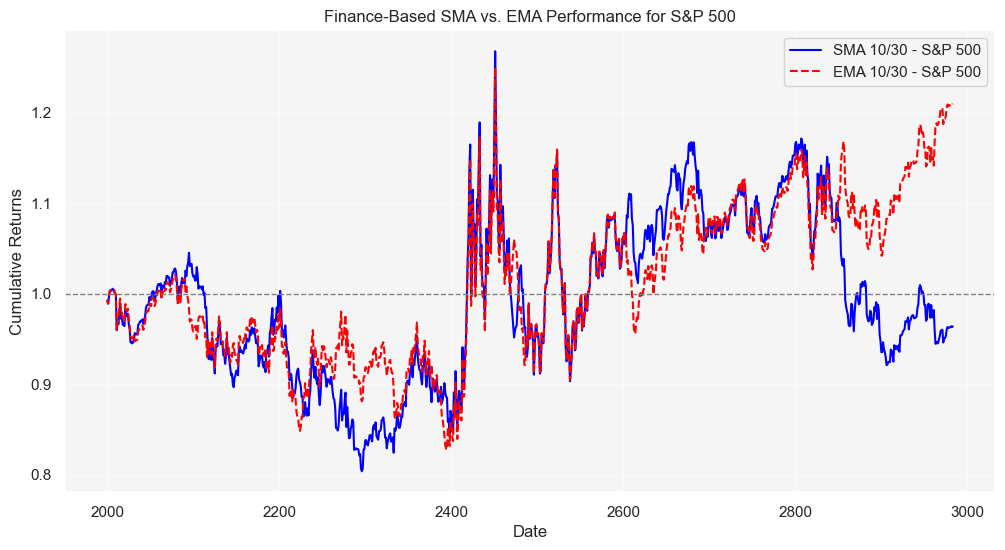

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.facecolor'] = '#f5f5f5'

def calculate_finance_sharpe_ratio(returns, risk_free_rate=0.0):
    """
    Calculates the annualized Sharpe ratio.
    - Uses 252 trading days per year for proper annualization.
    - Risk-free rate is assumed to be 0% but can be modified.
    """
    excess_returns = returns - risk_free_rate
    std = np.std(excess_returns)
    if std == 0:
        return np.nan
    return np.mean(excess_returns) / std * np.sqrt(252)  # Annualization factor

def implement_finance_sma_ema(df, instrument_name):
    """
    Implements both SMA 10/30 and EMA 10/30 crossover trading systems.
    - SMA uses simple moving averages for long-term trend identification.
    - EMA uses exponential weighting for a faster response to price changes.
    - Returns are calculated based on percentage changes in the synthetic price.
    """
    df = df.copy()

    # Identify the synthetic price column (required for calculations)
    syn_price_col = next((col for col in df.columns if 'Syn' in col), None)
    if syn_price_col is None:
        raise ValueError(f"No synthetic price column found in {instrument_name} data.")

    # Convert Date column to datetime if necessary
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%Y%m%d')
        df = df.dropna(subset=['Date'])
        df = df.sort_values('Date')
        df.set_index('Date', inplace=True)

    # Calculate daily returns if not already available
    df['Returns'] = df[syn_price_col].pct_change()

    # Implement SMA 10/30 system
    df['sma10'] = df[syn_price_col].rolling(window=10).mean()
    df['sma30'] = df[syn_price_col].rolling(window=30).mean()
    df['sma_signal'] = np.where(df['sma10'] > df['sma30'], 1, -1)  # Buy if short MA > long MA
    df['RetSMA10/30'] = df['sma_signal'].shift(1) * df['Returns']  # Shift to avoid lookahead bias

    # Implement EMA 10/30 system
    df['ema10'] = df[syn_price_col].ewm(span=10, adjust=False).mean()
    df['ema30'] = df[syn_price_col].ewm(span=30, adjust=False).mean()
    df['ema_signal'] = np.where(df['ema10'] > df['ema30'], 1, -1)  # Buy if short EMA > long EMA
    df['RetEMA10/30'] = df['ema_signal'].shift(1) * df['Returns']

    return df

def compare_finance_sma_vs_ema(euro_data, ty_data, sp_data):
    """
    Compares SMA 10/30 and EMA 10/30 strategies across three instruments:
    - Euro (Currency)
    - Ten Year Note (Fixed Income)
    - S&P 500 (Equity)
    
    Uses Sharpe Ratios to evaluate performance and determine the best strategy for each.
    """
    euro = implement_finance_sma_ema(euro_data, "Euro")
    ty = implement_finance_sma_ema(ty_data, "Ten Year Note")
    sp = implement_finance_sma_ema(sp_data, "S&P 500")

    # Extract return series
    euro_sma_returns = euro['RetSMA10/30']
    euro_ema_returns = euro['RetEMA10/30']

    ty_sma_returns = ty['RetSMA10/30']
    ty_ema_returns = ty['RetEMA10/30']

    sp_sma_returns = sp['RetSMA10/30']
    sp_ema_returns = sp['RetEMA10/30']

    # Compute Sharpe Ratios (Annualized)
    start_date = '1999-04-16'
    euro_sharpe_sma = calculate_finance_sharpe_ratio(euro_sma_returns.loc[start_date:].dropna())
    euro_sharpe_ema = calculate_finance_sharpe_ratio(euro_ema_returns.loc[start_date:].dropna())

    ty_sharpe_sma = calculate_finance_sharpe_ratio(ty_sma_returns.loc[start_date:].dropna())
    ty_sharpe_ema = calculate_finance_sharpe_ratio(ty_ema_returns.loc[start_date:].dropna())

    sp_sharpe_sma = calculate_finance_sharpe_ratio(sp_sma_returns.loc[start_date:].dropna())
    sp_sharpe_ema = calculate_finance_sharpe_ratio(sp_ema_returns.loc[start_date:].dropna())

    print("\nFinance-Based Comparison of SMA 10/30 vs. EMA 10/30")
    print(f"Euro SMA 10/30 Sharpe Ratio: {euro_sharpe_sma:.2f} vs EMA 10/30: {euro_sharpe_ema:.2f}")
    print(f"Ten Year Note SMA 10/30 Sharpe Ratio: {ty_sharpe_sma:.2f} vs EMA 10/30: {ty_sharpe_ema:.2f}")
    print(f"S&P 500 SMA 10/30 Sharpe Ratio: {sp_sharpe_sma:.2f} vs EMA 10/30: {sp_sharpe_ema:.2f}\n")

    return euro, ty, sp

def plot_finance_ema_vs_sma(euro, ty, sp):
    """Plots cumulative returns for SMA 10/30 vs. EMA 10/30 for each instrument."""
    
    instruments = {'Euro': euro, 'Ten Year Note': ty, 'S&P 500': sp}
    
    for instrument, df in instruments.items():
        start_date = '1999-04-16'
        
        # Compute cumulative returns
        cum_sma = (1 + df['RetSMA10/30'].loc[start_date:].dropna()).cumprod()
        cum_ema = (1 + df['RetEMA10/30'].loc[start_date:].dropna()).cumprod()

        # Plot comparison
        plt.figure(figsize=(12, 6))
        plt.plot(cum_sma, label=f"SMA 10/30 - {instrument}", linestyle='-', color='blue')
        plt.plot(cum_ema, label=f"EMA 10/30 - {instrument}", linestyle='--', color='red')
        plt.axhline(1, color='gray', linestyle='--', linewidth=1)
        plt.title(f"Finance-Based SMA vs. EMA Performance for {instrument}")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Returns")
        plt.legend()
        plt.show()

if __name__ == "__main__":
    # Load data
    excel_file = pd.ExcelFile(r"C:\Users\shrav\Downloads\assignment_TREND_data (4).xlsx")
    euro_data = excel_file.parse("uro")
    ten_year_note_data = excel_file.parse("ty")
    sp500_data = excel_file.parse("sp")

    # Compare strategies
    euro, ty, sp = compare_finance_sma_vs_ema(euro_data, ten_year_note_data, sp500_data)

    # Plot results
    plot_finance_ema_vs_sma(euro, ty, sp)

### **Comparison of SMA 10/30 vs. EMA 10/30**

### **Sharpe Ratio Results**

| Instrument         | SMA 10/30 Sharpe Ratio | EMA 10/30 Sharpe Ratio | Preferred Strategy |
|-------------------|----------------------|----------------------|------------------|
| **Euro**         | **0.39**              | **0.37**              | **SMA 10/30**    |
| **Ten Year Note** | **0.78**              | **0.45**              | **SMA 10/30**    |
| **S&P 500**       | **0.11**              | **0.32**              | **EMA 10/30**    |

### **Analysis**
1. **SMA 10/30 outperforms EMA 10/30 for Euro and Ten Year Note.**  
   - These assets tend to follow long-term trends, making SMA a better filtering method.
   - Ten Year Note has the highest Sharpe Ratio (**0.78**), showing strong trend-following behavior.

2. **EMA 10/30 performs better for the S&P 500.**  
   - Stocks exhibit more short-term volatility and mean reversion.
   - The faster response of EMA allows it to adapt to price movements more efficiently.

3. **The choice of moving average strategy depends on market structure.**  
   - **Trend-following instruments** like bonds and currencies benefit from SMA.
   - **Equities**, which are more mean-reverting, respond better to EMA.